In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import pearsonr

IMPORT CYTOSINE REPORTS


In [2]:
def import_cyt_report(directory):
    columns_cytosine_report = ['chrom', 'pos', 'strand', 'count_methylated', 'count_unmethylated', 'C-context', 'trinucleotide_context']
    datatypes = {'chrom': str, 'pos': int , 'strand': str, 'count_methylated': int, 'count_unmethylated': int, 'C-context': str, 'trinucleotide_context': str}
    cytosine_reports = {}
    
    # Iterate over subfolders in the directory
    for subfolder in os.listdir(directory):
        patient_id, _, _ = subfolder.split('_')
        cyt_report_path = os.path.join(directory, subfolder, 'cytosine_report.txt.CpG_report.txt')
        cytosine_reports[int(patient_id)] = pd.read_csv(cyt_report_path, sep='\t', names=columns_cytosine_report, dtype=datatypes)
    
    # Sort dictionary keys (patient IDs) and create a new dictionary with sorted keys
    sorted_cytosine_reports = {k: cytosine_reports[k] for k in sorted(cytosine_reports)}
    
    return sorted_cytosine_reports

# Example usage:
dir = '/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/bismark/methylation_call_raw/TET2'
cytosine_reports = import_cyt_report(dir)


In [17]:
dir_NZM = '/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/bismark/methylation_call_raw/NZM'
dir_DNMT3A = '/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/bismark/methylation_call_raw/DNMT3A'

In [18]:
cytosine_reports_NZM = import_cyt_report(dir_NZM)

In [19]:
cytosine_reports_DNMT3A = import_cyt_report(dir_DNMT3A)

TET2

In [3]:
#CHECK IF WE HAVE THE SAME POSITIONS
for patient in cytosine_reports:
    print(cytosine_reports[patient].shape)

(43816016, 7)
(43816016, 7)
(43816016, 7)
(43816016, 7)
(43816016, 7)


In [4]:
print(cytosine_reports.keys())

dict_keys([1, 2, 3, 4, 5])


CREATE A CORRELATION MATRIX

In [5]:
# Initialize correlation matrix with zeros
correlation_matrix = np.zeros((len(cytosine_reports), len(cytosine_reports)))

# Iterate over keys (sample IDs) in cytosine_reports
for i, m1 in enumerate(cytosine_reports.keys()):
    m1_counts = cytosine_reports[m1][['count_methylated', 'count_unmethylated']].values
    for j, m2 in enumerate(cytosine_reports.keys()):
        m2_counts = cytosine_reports[m2][['count_methylated', 'count_unmethylated']].values
        m1_flat = m1_counts.flatten()
        m2_flat = m2_counts.flatten()
        
        
        correlation_coefficient, _ = pearsonr(m1_counts.flatten(), m2_counts.flatten())
        correlation_matrix[i, j] = correlation_coefficient

print(correlation_matrix)

        
        

[[1.00000000e+00 2.62519277e-05 4.57797880e-05 2.51436361e-04
  2.23308825e-04]
 [2.62519277e-05 1.00000000e+00 7.30664540e-05 1.24966691e-04
  6.87287039e-05]
 [4.57797880e-05 7.30664540e-05 1.00000000e+00 1.98832482e-04
  1.09455717e-04]
 [2.51436361e-04 1.24966691e-04 1.98832482e-04 1.00000000e+00
  3.92715572e-04]
 [2.23308825e-04 6.87287039e-05 1.09455717e-04 3.92715572e-04
  1.00000000e+00]]


MAKE A HEATMAP OUT OF CORRELATION MATRIX

In [12]:
def make_heatmap(cor_matrix):
    plt.figure(figsize=(20, 20))

    # Create DataFrame with index and column labels
    columns = [i for i in range(1, 6)]  # Example column labels
    index = [i for i in range(1, 6)]     # Example index labels
    df_cor = pd.DataFrame(cor_matrix, index=index, columns=columns)

    # Plot heatmap with annotations
    sns.heatmap(df_cor, annot=True, vmin=2.6e-05, vmax=0.0005)

    # Set x-axis ticks at the top
    plt.gca().xaxis.tick_top()

    # Show plot
    plt.savefig('TET2_heatmap_covered.jpg')
    plt.show()

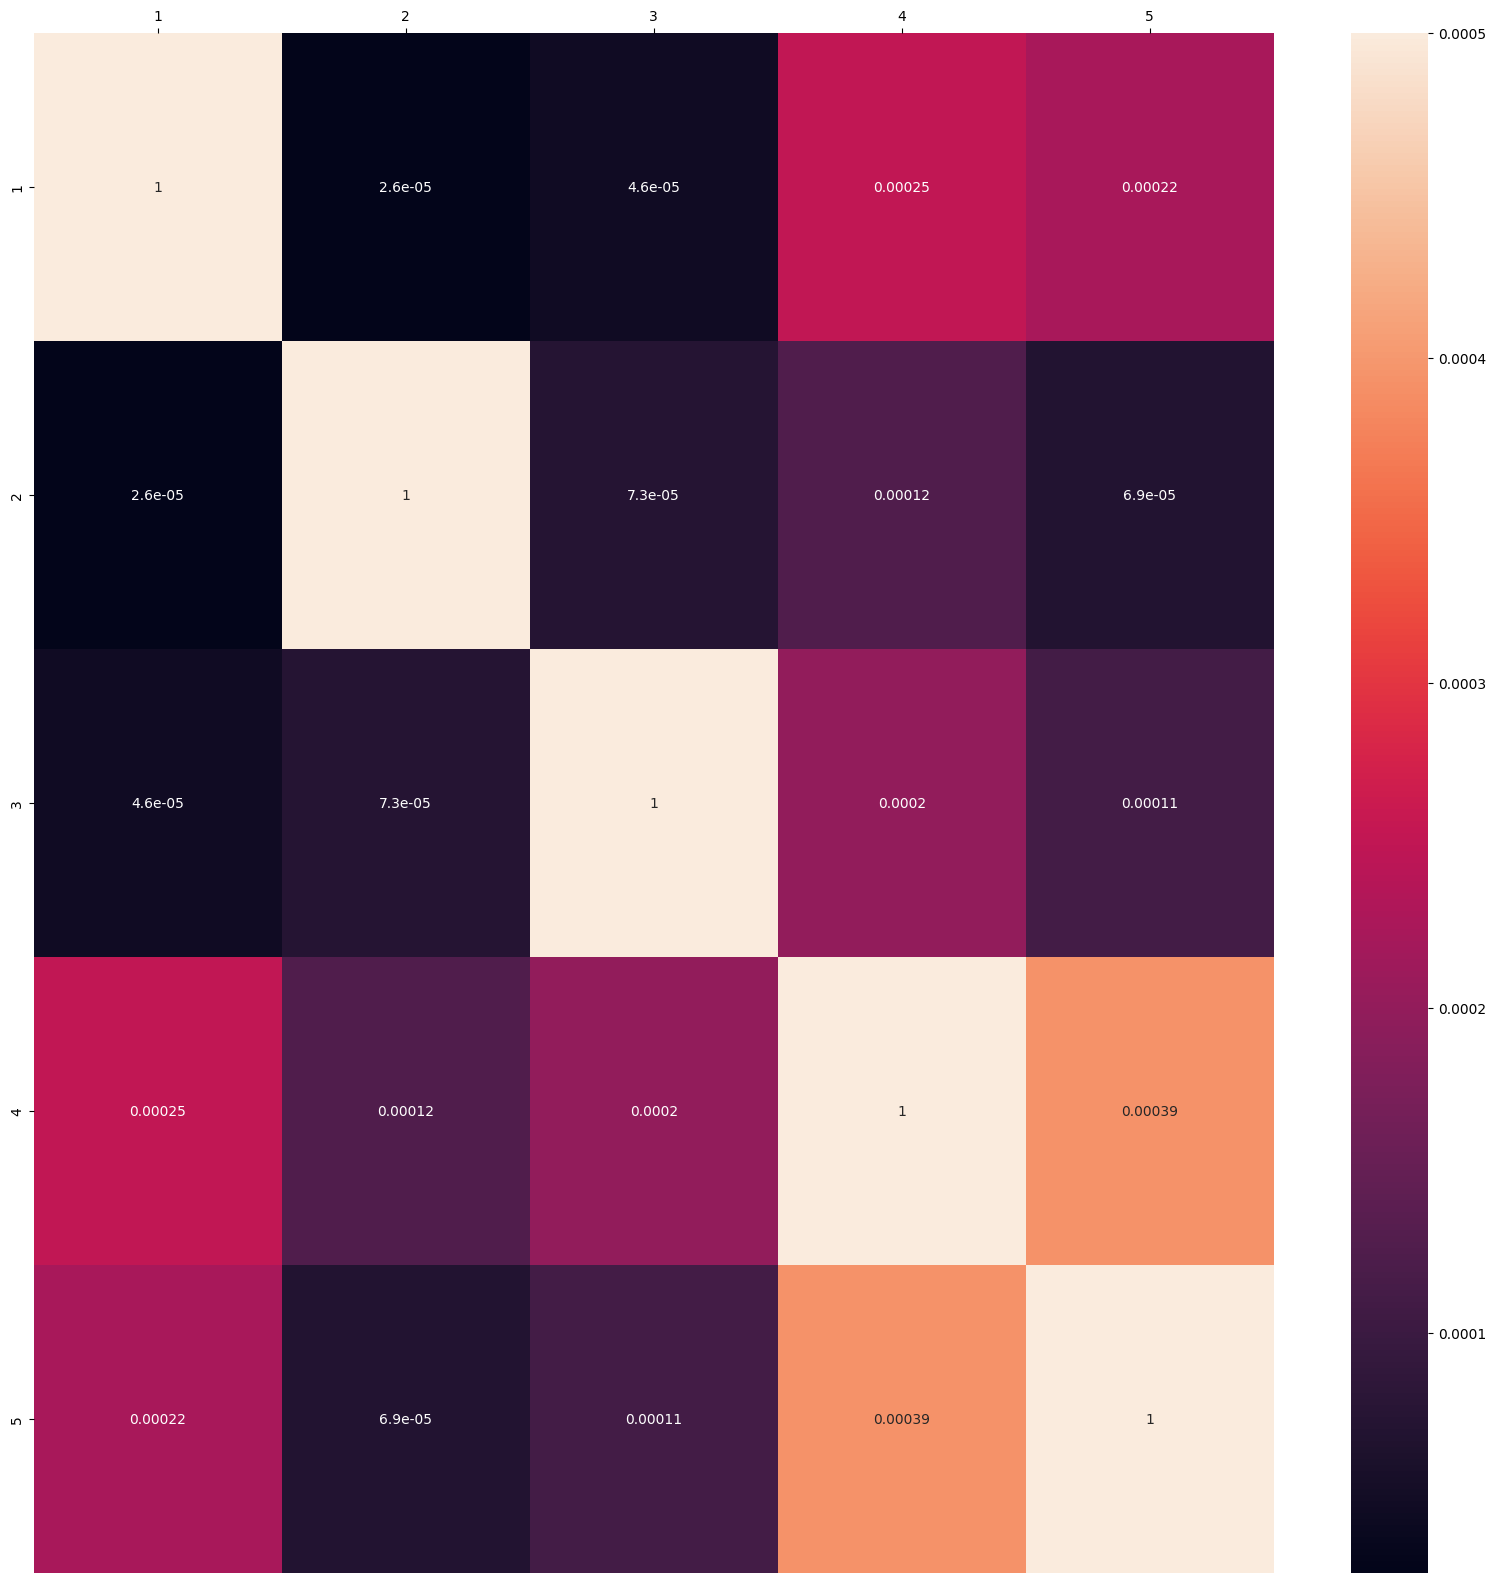

In [8]:
make_heatmap(correlation_matrix)

In [14]:
# Only use methylated count in correlation
correlation_matrix_meth = np.zeros((len(cytosine_reports), len(cytosine_reports)))

# Iterate over keys (sample IDs) in cytosine_reports
for i, m1 in enumerate(cytosine_reports.keys()):
    m1_counts = cytosine_reports[m1]['count_methylated'].values
    print(m1_counts.shape)
    for j, m2 in enumerate(cytosine_reports.keys()):
        m2_counts = cytosine_reports[m2]['count_methylated'].values
        correlation_coefficient, _ = pearsonr(m1_counts.flatten(), m2_counts.flatten())
        correlation_matrix_meth[i, j] = correlation_coefficient

print(correlation_matrix_meth)



(43816016,)
(43816016,)
(43816016,)
(43816016,)
(43816016,)
[[ 1.00000000e+00 -8.09995043e-06 -1.55363389e-05  1.16750850e-04
   1.13951066e-04]
 [-8.09995043e-06  1.00000000e+00  1.65029462e-05  6.55014528e-06
   9.77724898e-06]
 [-1.55363389e-05  1.65029462e-05  1.00000000e+00  1.43358464e-05
   1.22414023e-05]
 [ 1.16750850e-04  6.55014528e-06  1.43358464e-05  1.00000000e+00
   1.76539714e-04]
 [ 1.13951066e-04  9.77724898e-06  1.22414023e-05  1.76539714e-04
   1.00000000e+00]]


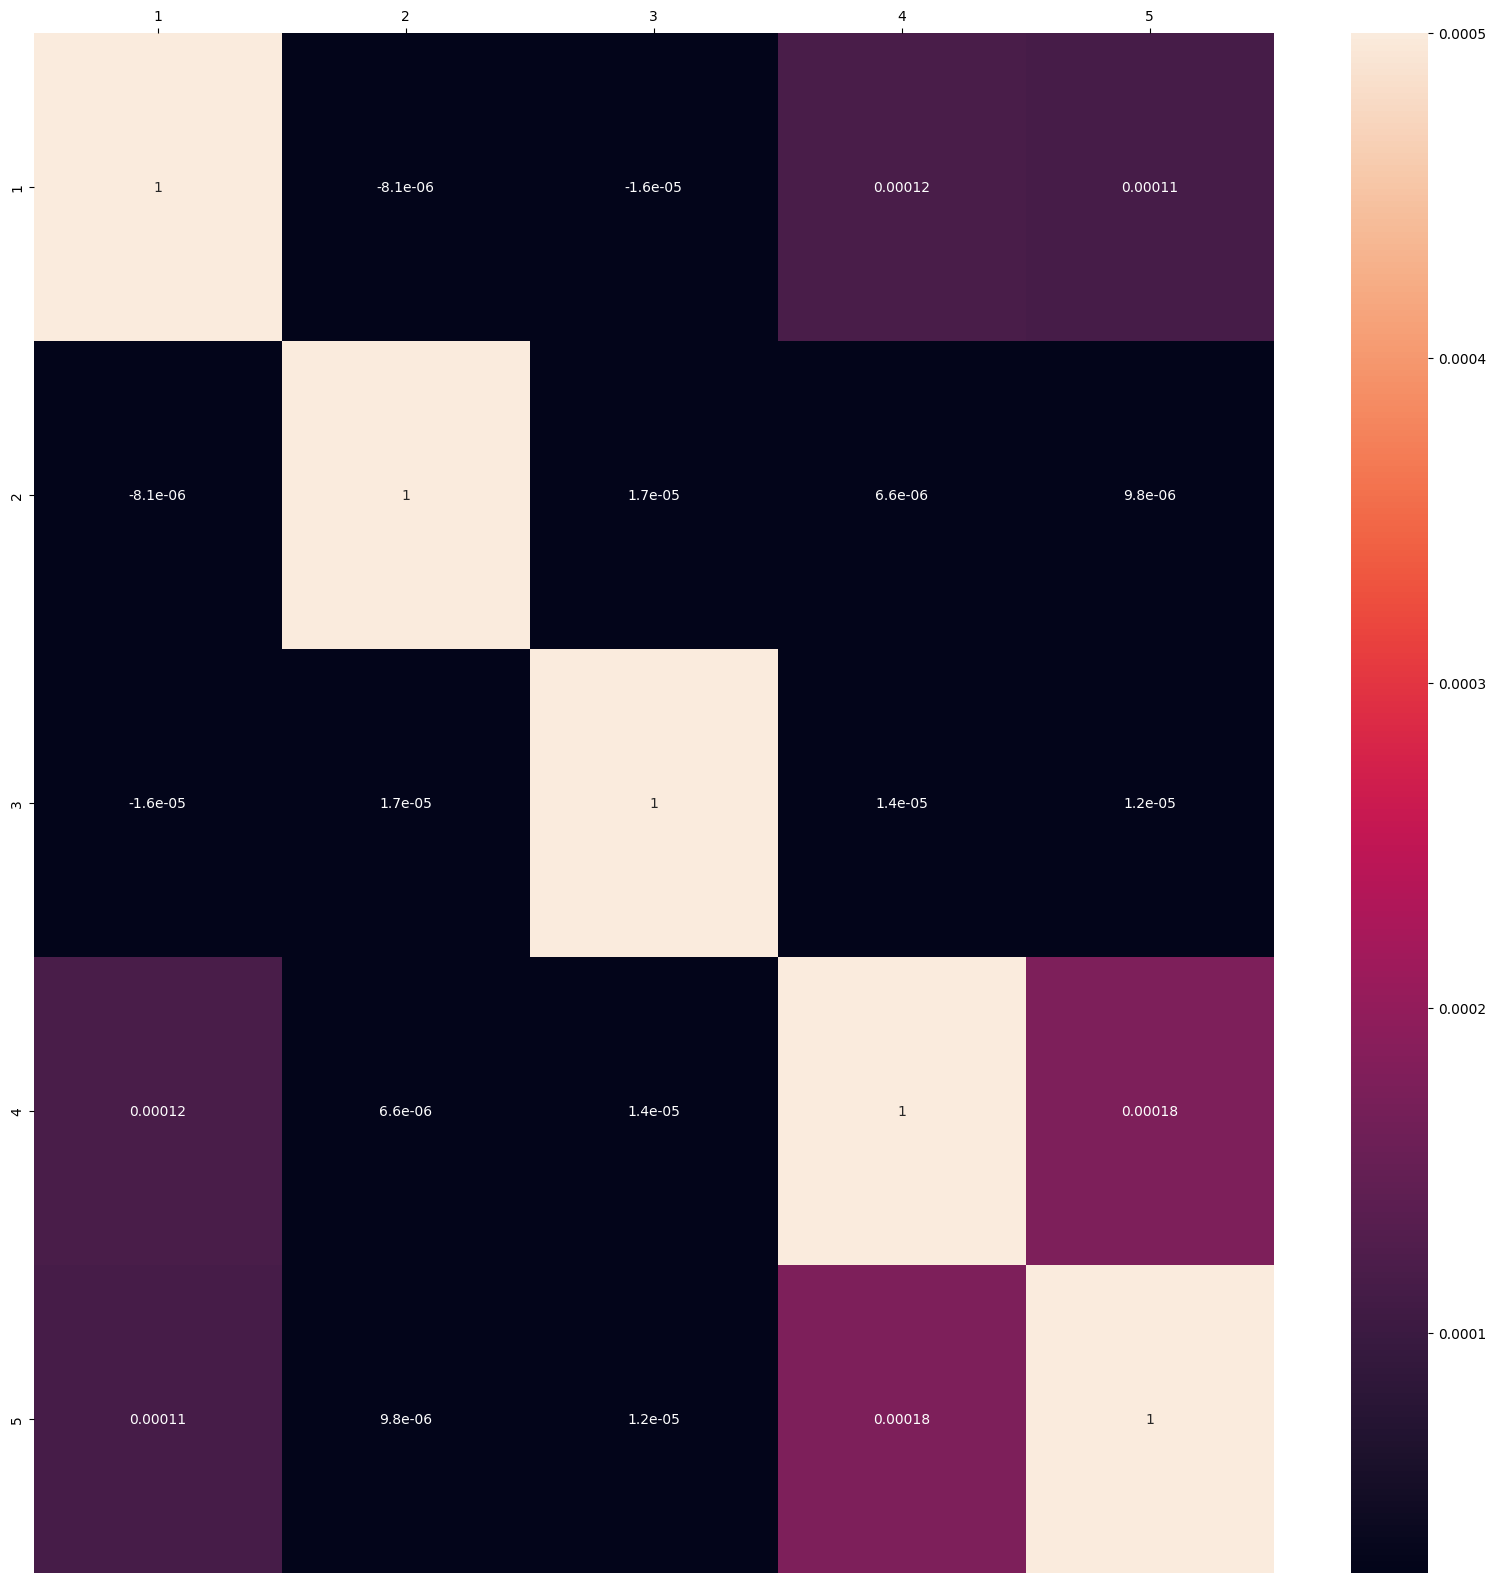

In [15]:
make_heatmap(correlation_matrix_meth)

In [13]:
def remove_uncovered(df):
    df2 = df.copy()
    df2 = df2[(df2['count_methylated'] != 0 ) | (df2['count_unmethylated'] != 0 )]
    return df2 
    
    

In [14]:
#cos tu jest zle, bo nie jest odbiciem lustrzanym 


def normalize_positions(df1, df2):
    #print('len df1: {}'.format(len(df1)))
    #print('len df2: {}'.format(len(df2)))
    
    merged_df = pd.merge(df1, df2, on=['pos', 'chrom'], how='inner')
    #print('len merged df' , len(merged_df))
    
    # Select only the rows from original dataframes where 'pos' is present in both
    merged_pos_chrom = set(zip(merged_df['pos'], merged_df['chrom']))  # Get unique (pos, chrom) pairs from merged_df
    df1_filtered = df1[(df1[['pos', 'chrom']].apply(tuple, axis=1)).apply(lambda x: x in merged_pos_chrom)]
    df2_filtered = df2[(df2[['pos', 'chrom']].apply(tuple, axis=1)).apply(lambda x: x in merged_pos_chrom)]
    
    #print('len df1: {}'.format(len(df1_filtered)))
    #print('len df2: {}'.format(len(df2_filtered)))
    if len(df1_filtered) != len(df2_filtered): 
        print('Not the same length - something wen wrong!')
        print(len(df1_filtered))
        print(len(df2_filtered))
    return df1_filtered, df2_filtered

    

In [15]:
#ASSUMPTION - THE POSITION HAS TO BE COVERED IN BOTH MICE FOR US TO COUNT IT 
# Initialize correlation matrix with zeros
correlation_matrix = np.zeros((len(cytosine_reports), len(cytosine_reports)))

# Iterate over keys (sample IDs) in cytosine_reports
for m1 in cytosine_reports.keys():
    df1 = cytosine_reports[m1] 
    df1_filt = remove_uncovered(df1)
    #print(df1_filt.info())
    for m2 in cytosine_reports.keys():
        df2 = cytosine_reports[m2] 
        df2_filt = remove_uncovered(df2)

        df1_filt, df2_filt = normalize_positions(df1_filt, df2_filt)
        m1_merged = pd.concat([df1_filt['count_methylated'], df1_filt['count_unmethylated']], axis=0)
        m2_merged = pd.concat([df2_filt['count_methylated'], df2_filt['count_unmethylated']], axis=0)
        
        
        correlation_coefficient, _ = pearsonr(m1_merged,m2_merged)
        correlation_matrix[m1 - 1, m2 - 1] = correlation_coefficient

print(correlation_matrix)


[[1.00000000e+00 8.85695290e-05 1.08255089e-04 1.88368482e-04
  1.95038526e-04]
 [8.85695290e-05 1.00000000e+00 8.53784132e-05 1.67775438e-04
  9.12968675e-05]
 [1.10049551e-04 8.53784132e-05 1.00000000e+00 1.97953492e-04
  8.81533103e-05]
 [2.78569259e-04 2.23659169e-04 1.97953492e-04 1.00000000e+00
  1.88185681e-04]
 [2.29508815e-04 1.25950896e-04 8.03726627e-05 1.88185681e-04
  1.00000000e+00]]


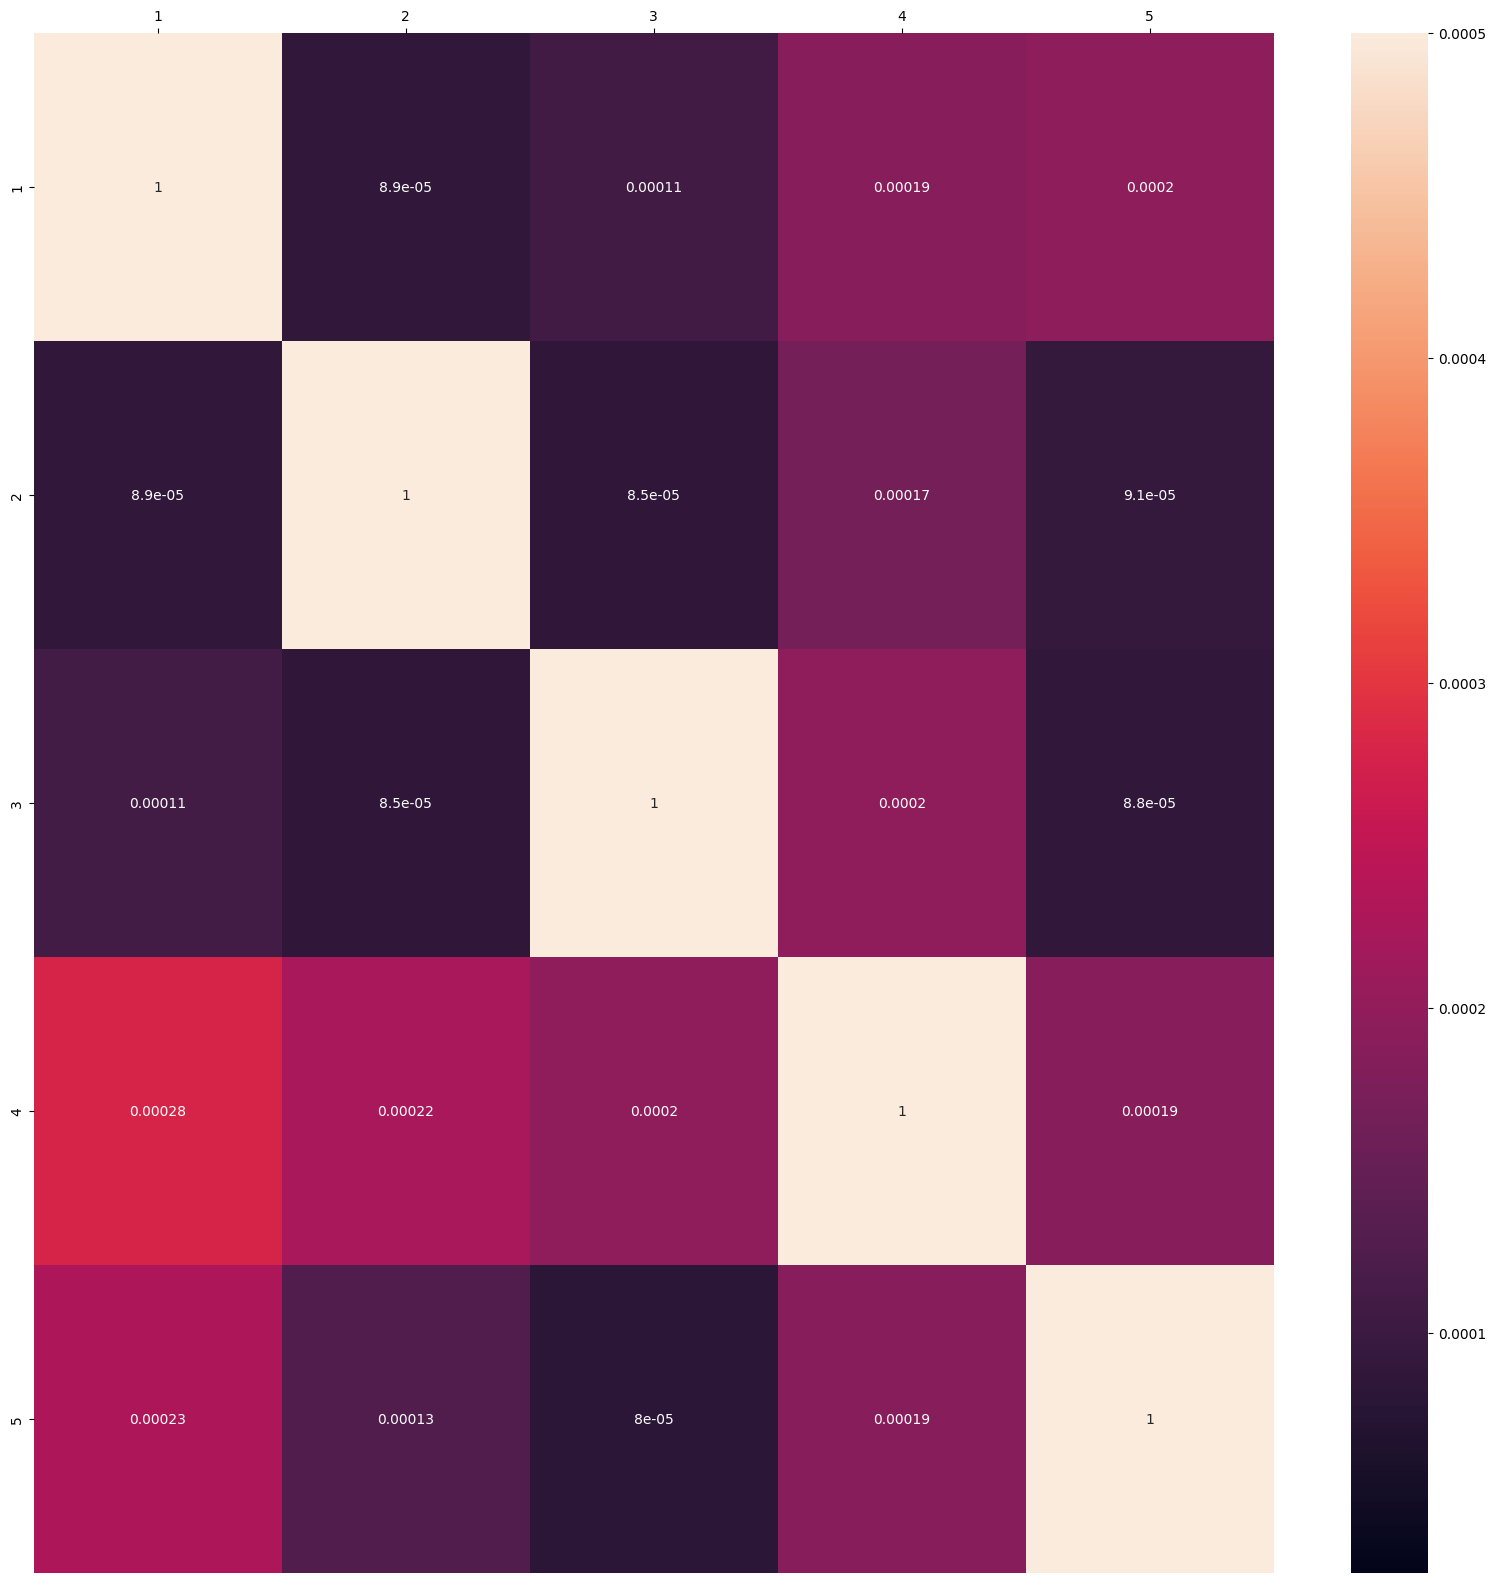

In [16]:
make_heatmap(correlation_matrix)